# TP2 — 00_rectify_and_disparity.ipynb

Este notebook valida el **pipeline inicial**: carga mapas de rectificación, rectifica un par L/R, calcula **SGBM**, visualiza la **disparidad** y genera una **nube 3D** de prueba.




In [28]:
# inspect_calibration.py  —  Sanidad de calibración estéreo + checks visuales
import glob, os, pickle
import numpy as np
import cv2 as cv

CALIB_PKL = r"C:\Users\andyd\Udesa\Vision Artificial\Reconstruccion-3D-Vision\data\stereo_calibration.pkl"
MAPS_PKL  = r"C:\Users\andyd\Udesa\Vision Artificial\Reconstruccion-3D-Vision\data\stereo_maps.pkl"
LEFT_GLOB  = r"C:\Users\andyd\Udesa\Vision Artificial\Reconstruccion-3D-Vision\data\calib\calib_left_*.jpg"   # usa una imagen de calib para checks
RIGHT_GLOB = r"C:\Users\andyd\Udesa\Vision Artificial\Reconstruccion-3D-Vision\data\calib\calib_right_*.jpg"

np.set_printoptions(precision=5, suppress=True)

def mat_info(name, M):
    print(f"{name}:\n{M}\n")

def main():
    with open(CALIB_PKL, "rb") as f: C = pickle.load(f)
    with open(MAPS_PKL, "rb") as f: M = pickle.load(f)

    K1, D1 = C["K1"], C["D1"].ravel()
    K2, D2 = C["K2"], C["D2"].ravel()
    R,  T  = C["R"],  C["T"].ravel()
    R1, R2, P1, P2, Q = C["R1"], C["R2"], C["P1"], C["P2"], C["Q"]

    print("=== INTRÍNSECOS ===")
    mat_info("K1", K1); print("D1:", D1, "\n")
    mat_info("K2", K2); print("D2:", D2, "\n")

    fx, fy = float(K1[0,0]), float(K1[1,1])
    cx, cy = float(K1[0,2]), float(K1[1,2])
    print(f"fx={fx:.2f}, fy={fy:.2f}, cx={cx:.2f}, cy={cy:.2f}, fx/fy={fx/fy:.3f}\n")

    print("=== ESTÉREO ===")
    mat_info("R", R); print(f"T (mm): {T}")
    ortho_err = np.linalg.norm(R.T @ R - np.eye(3))
    base = float(np.linalg.norm(T))
    print(f"‖RᵀR−I‖ = {ortho_err:.3e}")
    print(f"Baseline ||T|| = {base:.2f} mm,  Tx={float(T[0]):.2f} mm\n")

    print("=== RECTIFICACIÓN / Q ===")
    mat_info("R1", R1); mat_info("R2", R2)
    mat_info("P1", P1); mat_info("P2", P2)
    mat_info("Q", Q)
    print(f"Chequeo rápido Q: Q[2,3]≈f = {float(Q[2,3]):.3f},  Q[3,2]≈1/Tx = {float(Q[3,2]):.8f}\n")

    # ---------- Checks visuales ----------
    Lp = sorted(glob.glob(LEFT_GLOB)); Rp = sorted(glob.glob(RIGHT_GLOB))
    if not (Lp and Rp):
        print("[WARN] No encontré imágenes de calib para checks visuales."); return

    L = cv.imread(Lp[0]); Rimg = cv.imread(Rp[0])
    h, w = L.shape[:2]
    print(f"Resolución imágenes de calib: {w}x{h}\n")

    # Epipolares horizontales
    lmx, lmy, rmx, rmy = M["left_map_x"], M["left_map_y"], M["right_map_x"], M["right_map_y"]
    Lr = cv.remap(L, lmx, lmy, cv.INTER_LINEAR)
    Rr = cv.remap(Rimg, rmx, rmy, cv.INTER_LINEAR)
    side = cv.hconcat([Lr.copy(), Rr.copy()])
    for y in np.linspace(20, h-20, 12, dtype=int):
        cv.line(side, (0,y), (side.shape[1]-1, y), (0,255,0), 1)
    os.makedirs("report/figures", exist_ok=True)
    cv.imwrite("report/figures/_check_rect_epipolares.png", side)
    print("[OK] Fig: report/figures/_check_rect_epipolares.png")

    # Disparidad y Z ~ fx*B/d
    Lg, Rg = cv.cvtColor(Lr, cv.COLOR_BGR2GRAY), cv.cvtColor(Rr, cv.COLOR_BGR2GRAY)
    sgbm = cv.StereoSGBM_create(minDisparity=0, numDisparities=224, blockSize=7,
                                P1=8*3*49, P2=32*3*49, uniquenessRatio=8,
                                speckleWindowSize=100, speckleRange=2, disp12MaxDiff=1)
    disp = sgbm.compute(Lg, Rg).astype("float32")/16.0
    m = disp > 0
    if np.any(m):
        d50, d95 = np.percentile(disp[m], [50,95])
        Z = cv.reprojectImageTo3D(disp, Q)[m][:,2]
        z50, z95 = np.percentile(Z, [50,95])
        print(f"disp p50={d50:.1f}, p95={d95:.1f}  |  Z(mm) p50={z50:.1f}, p95={z95:.1f}")
        Z_est = fx*abs(float(T[0]))/d50
        print(f"Z_est ≈ fx*|Tx|/median(d) = {Z_est:.1f} mm")

        # --- Visualización robusta (NumPy 2.0) ---
        dmin = float(np.min(disp[m]))
        rng  = float(np.ptp(disp[m]))     # reemplaza disp[m].ptp()
        disp_vis = (255.0*(disp - dmin)/(rng + 1e-6)).clip(0,255).astype('uint8')
        cv.imwrite("report/figures/_check_disp.png", disp_vis)
        print("[OK] Fig: report/figures/_check_disp.png")
    else:
        print("[WARN] Disparidad sin píxeles válidos (revisar rectificación/numDisparities).")

if __name__ == "__main__":
    main()


=== INTRÍNSECOS ===
K1:
[[600.92128   0.      963.92093]
 [  0.      600.70007 550.52334]
 [  0.        0.        1.     ]]

D1: [ 0.00496 -0.02328 -0.00022  0.00157  0.00357] 

K2:
[[596.96544   0.      957.95243]
 [  0.      598.29071 532.5182 ]
 [  0.        0.        1.     ]]

D2: [ 0.00003 -0.02146 -0.00049 -0.00068  0.00327] 

fx=600.92, fy=600.70, cx=963.92, cy=550.52, fx/fy=1.000

=== ESTÉREO ===
R:
[[ 0.9999  -0.00064  0.01427]
 [ 0.00046  0.99992  0.01296]
 [-0.01428 -0.01295  0.99981]]

T (mm): [-59.07613   1.99496  -2.97157]
‖RᵀR−I‖ = 2.348e-16
Baseline ||T|| = 59.18 mm,  Tx=-59.08 mm

=== RECTIFICACIÓN / Q ===
R1:
[[ 0.99734 -0.035    0.06401]
 [ 0.03458  0.99937  0.0077 ]
 [-0.06424 -0.00547  0.99792]]

R2:
[[ 0.99817 -0.03371  0.05021]
 [ 0.03404  0.9994  -0.00574]
 [-0.04999  0.00743  0.99872]]

P1:
[[599.49539   0.      812.17437   0.     ]
 [  0.      599.49539 536.4001    0.     ]
 [  0.        0.        1.        0.     ]]

P2:
[[   599.49539      0.         812.17

[OK] Guardado en: C:\Users\andyd\Udesa\Vision Artificial\Reconstruccion-3D-Vision\report\figures


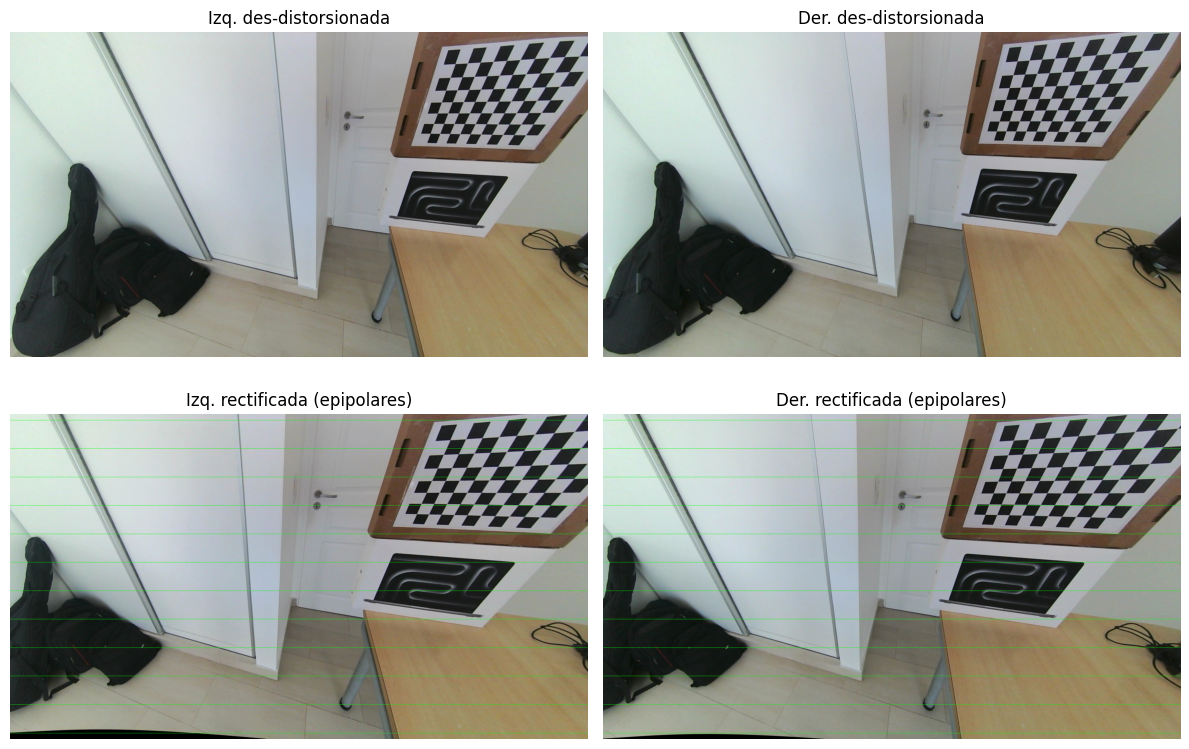

In [29]:
# src/report/export_rectified_examples.py
import os, glob, pickle
import numpy as np
import cv2 as cv

CALIB_PKL = r"C:\Users\andyd\Udesa\Vision Artificial\Reconstruccion-3D-Vision\data\stereo_calibration.pkl"
MAPS_PKL  = r"C:\Users\andyd\Udesa\Vision Artificial\Reconstruccion-3D-Vision\data\stereo_maps.pkl"
LEFT_GLOB  = r"C:\Users\andyd\Udesa\Vision Artificial\Reconstruccion-3D-Vision\data\calib\calib_left_*.jpg"    # par de ejemplo (calibración)
RIGHT_GLOB = r"C:\Users\andyd\Udesa\Vision Artificial\Reconstruccion-3D-Vision\data\calib\calib_right_*.jpg"
OUT_DIR = r"C:\Users\andyd\Udesa\Vision Artificial\Reconstruccion-3D-Vision\report\figures"

os.makedirs(OUT_DIR, exist_ok=True)

# ---- Cargar calibración y mapas ----
with open(CALIB_PKL, "rb") as f: C = pickle.load(f)
with open(MAPS_PKL, "rb") as f: M = pickle.load(f)

K1, D1 = C["K1"], C["D1"]
K2, D2 = C["K2"], C["D2"]
R1, R2 = C["R1"], C["R2"]
P1, P2 = C["P1"], C["P2"]
lmx, lmy = M["left_map_x"], M["left_map_y"]
rmx, rmy = M["right_map_x"], M["right_map_y"]

L_paths = sorted(glob.glob(LEFT_GLOB))
R_paths = sorted(glob.glob(RIGHT_GLOB))
assert len(L_paths) and len(L_paths)==len(R_paths), "No encontré pares calib_*."

# Tomamos el primero como ejemplo
imgL = cv.imread(L_paths[0])
imgR = cv.imread(R_paths[0])
h, w = imgL.shape[:2]

# ---- 1) Des-distorsionar (sin rectificar) ----
# newCameraMatrix = P sin baseline; usamos getOptimalNewCameraMatrix para no recortar
newK1, _ = cv.getOptimalNewCameraMatrix(K1, D1, (w,h), 0)
newK2, _ = cv.getOptimalNewCameraMatrix(K2, D2, (w,h), 0)

undL = cv.undistort(imgL, K1, D1, None, newK1)
undR = cv.undistort(imgR, K2, D2, None, newK2)

cv.imwrite(os.path.join(OUT_DIR, "undist_left.png"),  undL)
cv.imwrite(os.path.join(OUT_DIR, "undist_right.png"), undR)

# ---- 2) Rectificar (remap con mapas) ----
Lr = cv.remap(imgL, lmx, lmy, cv.INTER_LINEAR)
Rr = cv.remap(imgR, rmx, rmy, cv.INTER_LINEAR)
cv.imwrite(os.path.join(OUT_DIR, "rect_left.png"),  Lr)
cv.imwrite(os.path.join(OUT_DIR, "rect_right.png"), Rr)

# ---- 3) Comparativa lado a lado con líneas epipolares ----
def draw_epilines(im, n=12, color=(0,255,0)):
    out = im.copy()
    h = out.shape[0]
    for y in np.linspace(20, h-20, n, dtype=int):
        cv.line(out, (0,y), (out.shape[1]-1, y), color, 1)
    return out

Lr_lines = draw_epilines(Lr)
Rr_lines = draw_epilines(Rr)
side = cv.hconcat([Lr_lines, Rr_lines])
cv.imwrite(os.path.join(OUT_DIR, "rect_side_by_side_epilines.png"), side)

# ---- 4) (Opcional) Figura 2×2 con texto ----
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,8))
    plt.subplot(2,2,1); plt.imshow(cv.cvtColor(undL, cv.COLOR_BGR2RGB)); plt.title("Izq. des-distorsionada"); plt.axis('off')
    plt.subplot(2,2,2); plt.imshow(cv.cvtColor(undR, cv.COLOR_BGR2RGB)); plt.title("Der. des-distorsionada"); plt.axis('off')
    plt.subplot(2,2,3); plt.imshow(cv.cvtColor(Lr_lines, cv.COLOR_BGR2RGB)); plt.title("Izq. rectificada (epipolares)"); plt.axis('off')
    plt.subplot(2,2,4); plt.imshow(cv.cvtColor(Rr_lines, cv.COLOR_BGR2RGB)); plt.title("Der. rectificada (epipolares)"); plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "rect_undist_grid.png"), dpi=200)
except Exception:
    pass

print("[OK] Guardado en:", OUT_DIR)


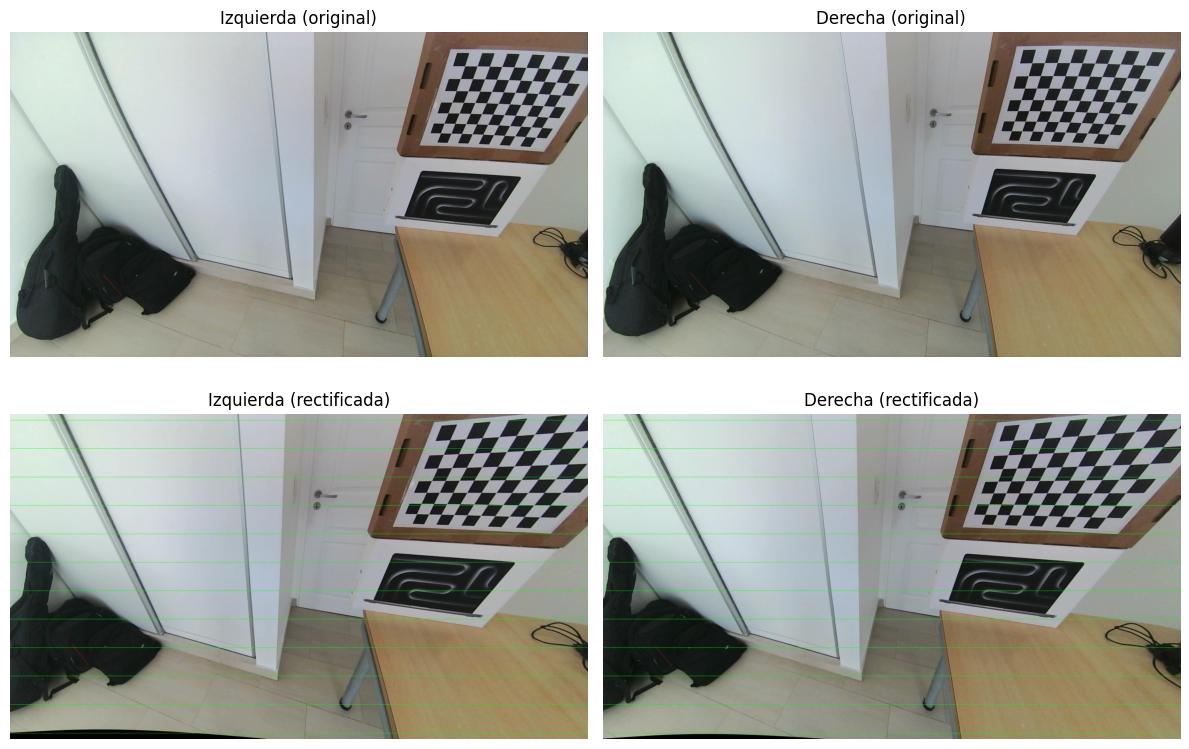

[OK] Figuras guardadas en C:\Users\andyd\Udesa\Vision Artificial\Reconstruccion-3D-Vision\report\figures


In [30]:
# === Plot: originales vs rectificadas (con epipolares) ===
import os, glob, pickle
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# --- Config ---
MAPS_PKL  = r"C:\Users\andyd\Udesa\Vision Artificial\Reconstruccion-3D-Vision\data\stereo_maps.pkl"
LEFT_GLOB  = r"C:\Users\andyd\Udesa\Vision Artificial\Reconstruccion-3D-Vision\data\calib\calib_left_*.jpg"    # o "data/captures/left_*.jpg"
RIGHT_GLOB = r"C:\Users\andyd\Udesa\Vision Artificial\Reconstruccion-3D-Vision\data\calib\calib_right_*.jpg"   # o "data/captures/right_*.jpg"
OUT_DIR = r"C:\Users\andyd\Udesa\Vision Artificial\Reconstruccion-3D-Vision\report\figures"
os.makedirs(OUT_DIR, exist_ok=True)

# --- Util: dibujar epipolares horizontales ---
def draw_epilines(im_bgr, n=12, color=(0,255,0)):
    out = im_bgr.copy()
    h = out.shape[0]
    for y in np.linspace(20, h-20, n, dtype=int):
        cv.line(out, (0,y), (out.shape[1]-1, y), color, 1)
    return out

# --- Cargar mapas de rectificación ---
with open(MAPS_PKL, "rb") as f:
    M = pickle.load(f)
lmx, lmy = M["left_map_x"], M["left_map_y"]
rmx, rmy = M["right_map_x"], M["right_map_y"]

# --- Tomar un par ---
Lp = sorted(glob.glob(LEFT_GLOB))
Rp = sorted(glob.glob(RIGHT_GLOB))
assert Lp and Rp and len(Lp)==len(Rp), "No encontré pares L/R."
L = cv.imread(Lp[0]); R = cv.imread(Rp[0])

# --- Rectificar (remap = des-distorsión + alineación epipolar) ---
Lr = cv.remap(L, lmx, lmy, cv.INTER_LINEAR)
Rr = cv.remap(R, rmx, rmy, cv.INTER_LINEAR)

# --- Guardar archivos sueltos (útil para el informe) ---
cv.imwrite(os.path.join(OUT_DIR, "orig_left.png"),  L)
cv.imwrite(os.path.join(OUT_DIR, "orig_right.png"), R)
cv.imwrite(os.path.join(OUT_DIR, "rect_left.png"),  Lr)
cv.imwrite(os.path.join(OUT_DIR, "rect_right.png"), Rr)
cv.imwrite(os.path.join(OUT_DIR, "rect_side_by_side_epilines.png"),
           cv.hconcat([draw_epilines(Lr), draw_epilines(Rr)]))

# --- Mostrar en grid 2x2 ---
fig = plt.figure(figsize=(12,8))

plt.subplot(2,2,1); plt.imshow(cv.cvtColor(L,  cv.COLOR_BGR2RGB)); plt.title("Izquierda (original)"); plt.axis('off')
plt.subplot(2,2,2); plt.imshow(cv.cvtColor(R,  cv.COLOR_BGR2RGB)); plt.title("Derecha (original)");   plt.axis('off')
plt.subplot(2,2,3); plt.imshow(cv.cvtColor(draw_epilines(Lr), cv.COLOR_BGR2RGB)); plt.title("Izquierda (rectificada)"); plt.axis('off')
plt.subplot(2,2,4); plt.imshow(cv.cvtColor(draw_epilines(Rr), cv.COLOR_BGR2RGB)); plt.title("Derecha (rectificada)");   plt.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "orig_vs_rect_grid.png"), dpi=200)
plt.show()

print("[OK] Figuras guardadas en", OUT_DIR)
